# Abrupt Fires and Landslides
Authors: Nick Colaianne, David Cúñez, Sebastien Lenard, Jill Marshall, Emily Rexer

## Background and Motivation
Landslides have shaped steep terrain for millenia. With climate change, the threat of increasing fires (both in severity and frequency), combined with increasing storm intensity, pose a risk to communities, infrastructure, and ecosystems.

Here, we focus on a short-timescale question on the coupled role of fires and landslides in modifying sediment fluxes and landscape topography. Our focus area is in the well-studied Oregon Coast Range, allowing for the use of measured parameters in the model. For the purposes of this simplified simulation we ignore vegetation regrowth, uplift, and soil production.

Mass wasting and landslides are major processes affecting the erosion of the Earth's surface but their study remains difficult as the erosion products can be rapidly evacuated during the rainy season. Numerical modeling allows to improve our knowledge of landsliding by simulating mountains and processes through numerical solving of the mathematical equations of the processes.

## Table of Contents
0. Imports and Helper Functions
1. Initializing the grid and its fields
2. [Stochastic Fire](https://landlab.readthedocs.io/en/latest/reference/components/fire_generator.html)
3. [Flow](https://landlab.readthedocs.io/en/master/reference/bmi/index.html?highlight=priorityflood#landlab.bmi.components.PriorityFloodFlowRouter), [BedrockLandslider](https://landlab.readthedocs.io/en/latest/reference/components/bedrock_landslider.html), and [SPACE](https://landlab.readthedocs.io/en/latest/reference/components/space.html#stream-power-with-alluvium-conservation-and-entrainment)

## 0. Imports and Helper Functions
Stochastic fire and pretty plots.

In [43]:
import copy, time, warnings
from datetime import timedelta
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.cbook
import matplotlib.pyplot as plt 
import warnings

from bmi_topography import Topography
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid
from landlab.io import read_esri_ascii
from landlab.components import (DepressionFinderAndRouter,
                                FlowAccumulator,
                                Space,
                                PriorityFloodFlowRouter,
                                BedrockLandslider,
                                )

# matplotlib warnings are suppressed for presentation purposes
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Modules are autoreloaded for easy modification
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Larger figures  
plt.rcParams["figure.figsize"] = [15, 15]

In [45]:
class ErodibilityStepper:
    """
    This class is initialized by a decay_constant, describing the rate at which
    the erodibility of burned areas recovers, and a baseline erodibility value Ksed0.
    """
    def __init__(self, decay_time=1, K_sed0=1):
        self.decay_time = decay_time
        self.K_sed0 = K_sed0
        
    def stepper(self, space, dt):
        """
        This method takes in  a space object "space",
        an equilibrium (in the absence of burning) erodibility Ksed0,
        and a timestep "space_dt" to modify the erodibility
        of `space` on each gridcell by one timestep by the equation
        dK/dt = -decay_const*(Ksed-Ksed0). 
        Describing a decay of the erodibility toward its equilibrium
        value Ksed_0
        """
        # solve the DE with simple Euler method
        dK_sed =  - (space.K_sed - self.K_sed0) * dt / self.decay_time # erodibility decay in time
        space.K_sed += dK_sed # modify the erodibility in place
        
class Burner:
    """
    This is initialized by a fire frequency, mean fire radius in units of the grid size,
    and the amount K_sed_boost by which the sediment erodibility is increased by fire.
    The method `fire` modifies (in place) the erodibility of nodes where the fire occurred.
    """
    def __init__(self, fire_freq=1, R_fire_mean=1, K_sed_boost=1, dt = 1, dx=1):
        """
        fire frequency -- how often fires occur [1/T]
        fire radius -- typical size of fires [L]
        K_sed_boost -- amount by which K_sed is increased by fire
        dt -- space model timestep.
        """
        self.fire_freq = fire_freq # average number of fires per unit time
        self.R_fire_mean = R_fire_mean # the radius of the fire... 
        self.K_sed_boost = K_sed_boost # the amount by which the sediment erodibility is increased by fire
        self.dt = dt # the timestep on which to evaluate the probability that a fire occurs
        self.fireTimes = [] # empty list to be filled with the times when fires happened
        self.fireSizes = [] # empty list to be filled with the sizes of fires that happened
        self.dx = dx # size of the grid used by space
        
    @property
    def R_fire(self):
        """
        choose a random fire size from an exponential distribution
        having mean size R_fire_mean
        """
        return np.random.exponential(self.R_fire_mean) # exponential random var
        
        
    def fire(self, space, grid, t):
        """
        Generates a fire at a random location within the grid.
        First calculates whether or not a fire occurs at the timestep.
        Then 
        """
        # fire occurs if:
        #    a random exceeds the probability that fire does not occur
        occurs = np.exp(-self.dt * self.fire_freq) < np.random.random() # prob fire does not occur < random 
        if not occurs:
            pass # do nothing. This comes first as it's the most common scenario.
        else: # if fire does occur
            K_sed = space.K_sed # get the array of sediment erodibilities before the fire
            # find the coordinates of this erodibility array which are to be changed
            center = np.random.choice(K_sed.size) # select a random node for the fire center
            # locate all nodes within R_fire of the center node.
            changed_nodes = self._within(center, space , grid) # based on Laurent's code.
            # modify those nodes only.. they should increase erodibility !
            K_sed[changed_nodes] += self.K_sed_boost # increase them by K_sed_boost
            # set these into the space object as the new erodibility
            space.K_sed = K_sed # modify in place. Erodibility is now boosted by the fire.
            # This occurs on all cells within proximity R_fire of the fire center

            # just a print block to explain what's happening...
            s1 = grid.x_of_node[center]
            s2 = grid.y_of_node[center]
            A = len(changed_nodes) * self.dx ** 2 / 1e6 # area of the fire if it occcurred
            # units of A are km^2. 
            print(r'fire at ({},{}) of area {} square km.'.format(s1,s2,round(A,2)))
            
            # save the time and magnitude of the fire
            self.fireTimes.append(t) # time at which the fire happened
            self.fireSizes.append(A) # area of the fire which happened.
                        
        
    def _within(self, center, space, grid):
        """
        return all nodes within distance R_fire of center within grid. Utility function.
        Takes:
            center -- a single index (i.e. '3') into the 1D array of nodes
            R_fire -- the radius of a fire in gridsize units
            space -- the SPACE object (called ha..)
            grid -- the RasterModelGrid object (called mg ..)
        """
        centerPoint = (grid.x_of_node[center], grid.y_of_node[center]) # the center of the fire
        mask = grid.calc_distances_of_nodes_to_point(centerPoint) < self.R_fire # mask of nodes in radius
        # all nodes within R_fire of the centerPoint
        return np.arange(mask.size)[mask] # return indices of all nodes within distance R_fire

In [46]:
def landslide_plot(grid):
    cmap1 = copy.copy(mpl.cm.get_cmap("Blues"))
    thres_drape1 = 0.01
    thres_drape2 = 0.01
    alpha  = .8
    alpha2 = .8
    drape1 = np.sqrt(grid.at_node["landslide__erosion"])
    drape2 = np.sqrt(grid.at_node["landslide__deposition"])
    cmap1 = copy.copy(mpl.cm.get_cmap("hot_r"))
    cmap2 = copy.copy(mpl.cm.get_cmap("winter_r"))
    plt.title('Erosion and Deposition after Landslides',fontsize=20)
    imshowhs_grid(grid, "topographic__elevation",
                  plot_name='Test',
                  plot_type='Drape2',         
                  drape1=drape1,
                  cmap=cmap1,
                  thres_drape1=thres_drape1,
                  alpha=alpha,
                  drape2=drape2,
                  cmap2=cmap2,
                  thres_drape2=thres_drape2,
                  alpha2=alpha2,
                  add_double_colorbar=True, 
                  cbar_tick_size=8,
                  cbar_label_color='red',
                  cbar_label_fontweight='normal',
                  add_label_bbox=True,
                  )
    plt.show()

## 1. Initializing the grid and its fields
Here, we use `bmi_topography` to obtain the 30m-STRM DEM covering a drainage basin in Oregon. We use this to create the grid and compute the topographic slope and topographic drainage area, which are added to the grid as fields for the landslide component. 

### 1.1 Download and Reproject the DEM.
We reproject the DEM into a new projected DEM with coordinates and cell-spacing in meters.

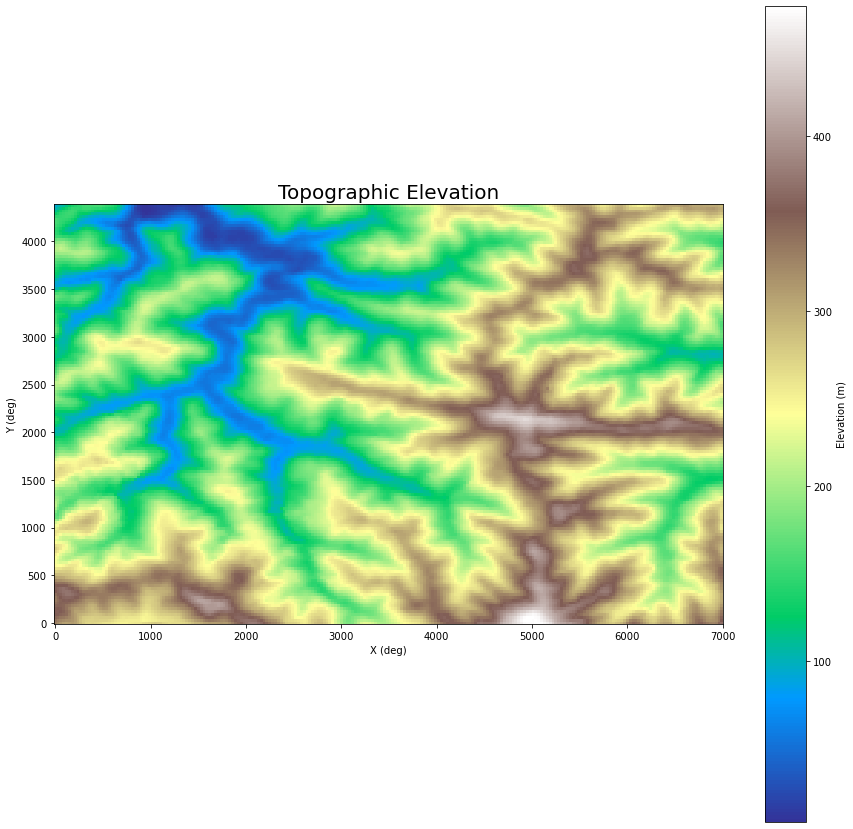

In [47]:
topo = Topography(
    dem_type="SRTMGL1",
    api_key='1f3ea82738663688170f0d898b59ca1d',
    south=43.972829,
    north=44.013602,
    west=-123.860848,
    east=-123.795973,
    output_format="AAIGrid",
    cache_dir="DEMData//"
    )

fname = topo.fetch()
dem = topo.load()
grid_geog, elev = read_esri_ascii(fname, name='topographic__elevation')    
cmap = copy.copy(mpl.cm.get_cmap("terrain"))
grid = RasterModelGrid((grid_geog.number_of_node_rows, grid_geog.number_of_node_columns), 30)
grid.add_field('topographic__elevation', elev, at='node')
dx = np.diff(grid.x_of_node)[0]

imshow_grid(grid, 
            'topographic__elevation',
            cmap=cmap,
            grid_units=("deg", "deg"),
            colorbar_label="Elevation (m)")
plt.title('Topographic Elevation', fontsize=20)
plt.show()

### 1.2 Set Constants

In [48]:
flow_metric = "D8"

# Timesteps, runtime, and uplift rate for wildfire simulation time window
timestep = 1                                  # timestep in years
simulation_length = 10                        # length of the simulation in years
num_timestep = simulation_length // timestep  # number of timesteps
uplift = 0.0001                               # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp = 0.00001            # erodibility coefficient
m_sp = 0.5                # Drainage area exponent
n_sp = 1                  # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# the initial soil erodibility per node
K_sed = np.ones(grid.shape) * K_sed0 

# Erodibility stepper
decay_time = timestep * 15    # time it takes the erodibility perturbutions to decay

# Burner
R_fire_mean = len(grid.x_of_node) * dx / 500    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1 / (2 * timestep)                  # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5 * K_sed0                        # The increase in sediment erodibility due to fire
K_sp = 0.00001                                  # erodibility coefficient
m_sp = 0.5                                      # Drainage area exponent
n_sp = 1                                        # Slope exponent

# BedrockLandSlider
# angle_internal_friction in m/m (tangent and not degrees)
angle_internal_friction = 0.5
# landslides_return_time = 1 -> probability of sliding 100%
lanslides_return_time = 1e2
# cohesion_eff: Effective cohesion of material [m L^-1 T^-2].
cohesion_eff = 1e3

### 1.3 Initializing soil properties
Soil properties are needed by the landlide component to compute landslide failure probability.

In [49]:
# Add soil to the drainage network (for SPACE)
_ = grid.add_zeros('soil__depth', at='node', dtype=float) 
grid.at_node['soil__depth'] += 0.5
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=False, 
    left_is_closed=False,
    right_is_closed=False, 
    top_is_closed=False
)

In [50]:
# Initialize components
flow_router = PriorityFloodFlowRouter(
    grid,
    surface="topographic__elevation",
    flow_metric=flow_metric,
    suppress_out=True,
    depression_handler="fill",
    accumulate_flow=True,
    separate_hill_flow=True,
    accumulate_flow_hill=True,
)
flow_accumulator = FlowAccumulator(grid, flow_director=flow_metric)
depression_finder = DepressionFinderAndRouter(grid)
space_model = Space(
    grid,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br
)
erodibility_stepper = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=timestep
               )
bedrock_landslider = BedrockLandslider(
    grid, 
    angle_int_frict=angle_internal_friction, 
    landslides_return_time=lanslides_return_time,
    cohesion_eff=cohesion_eff
)

Text(0.5, 1.0, 'Topographic Elevation')

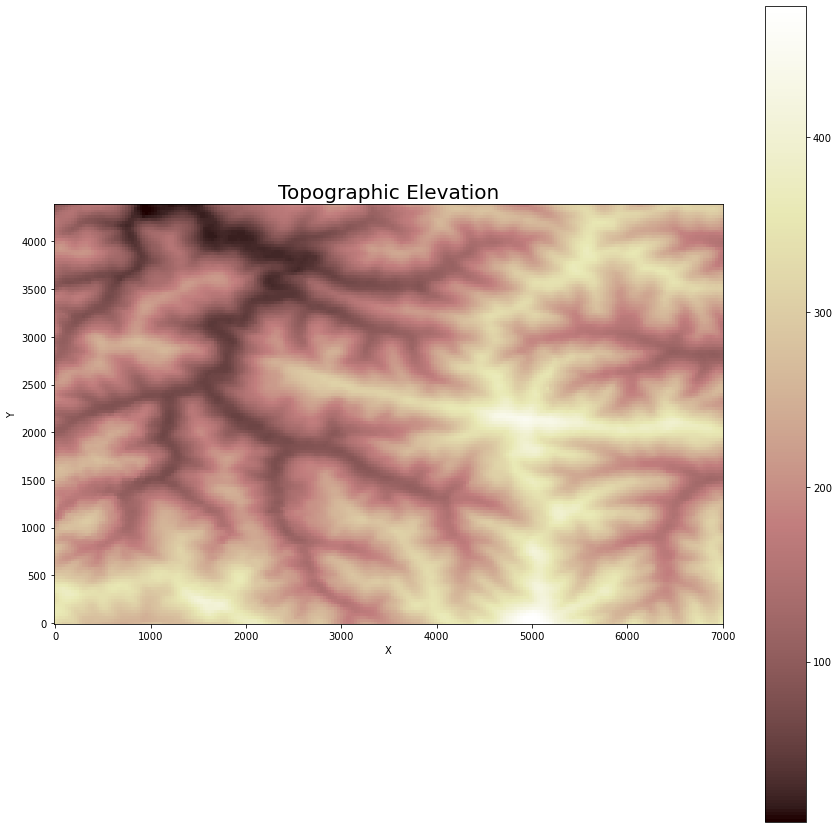

In [51]:
# Run the PriorityFloodFlowRouter first
flow_router.run_one_step()
imshow_grid(grid, "topographic__elevation")
plt.title('Topographic Elevation', fontsize=20)

## 2. Stochastic Fire

In [52]:
# Wildfire season
start_time = time.time()

for i in range(num_timestep): # iterate through timesteps
    space_model.run_one_step(dt=timestep)   # step the transport model
    erodibility_stepper.stepper(space_model, dt=timestep)     # decay the erodibility back toward baseline from the former timestep
    burner.fire(space_model, grid, i*timestep)          # light any fires (increase erodibility)
    grid.at_node['bedrock__elevation'][grid.core_nodes] += uplift * timestep # incorporate uplift
    grid.at_node['K_sed'] = K_sed
    if (i * timestep % 5 == 0): # if a decade has gone by, then print
        print("--", i*timestep, "years simulated -- %s seconds runtime --" % round((time.time() - start_time), 1))
        
print(f"runtime: {str(timedelta(seconds=(time.time() - start_time)))}")

-- 0 years simulated -- 8.3 seconds runtime --
fire at (2850.0,330.0) of area 0.01 square km.
fire at (4020.0,3240.0) of area 0.0 square km.
fire at (2940.0,2940.0) of area 0.03 square km.
fire at (510.0,3900.0) of area 0.0 square km.
-- 5 years simulated -- 50.1 seconds runtime --
fire at (4080.0,3480.0) of area 0.01 square km.
fire at (1470.0,3840.0) of area 0.01 square km.
runtime: 0:01:23.570145


Text(0.5, 1.0, 'Erodibility after a sequence of fires')

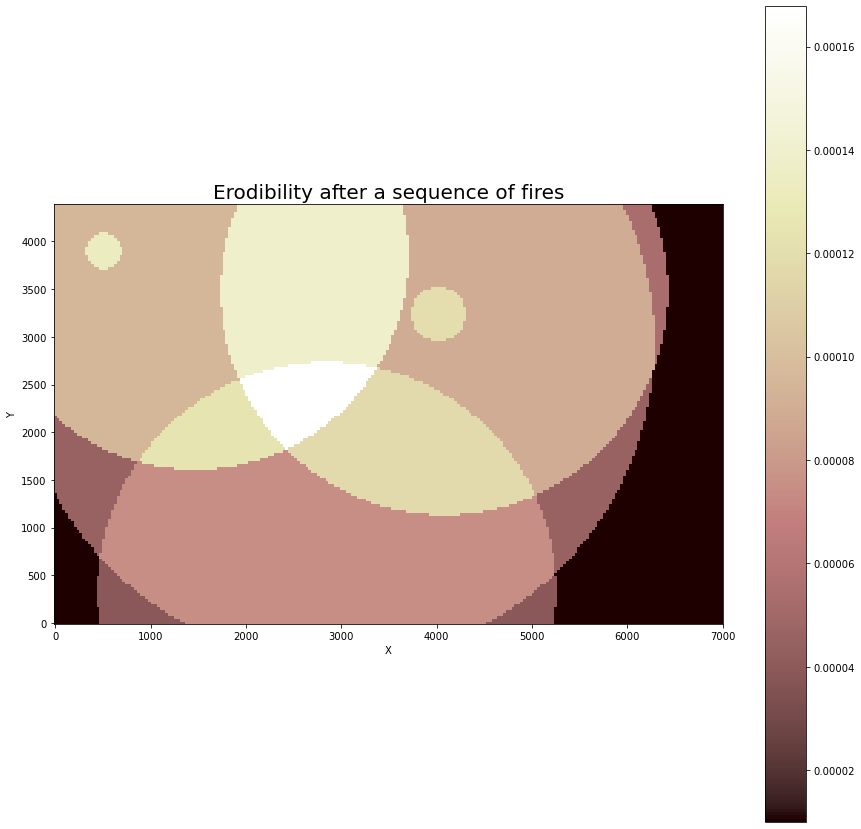

In [53]:
imshow_grid(grid, 'K_sed')
plt.title('Erodibility after a sequence of fires', fontsize=20)

Text(0.5, 1.0, 'Sediment Flux after a sequence of fires')

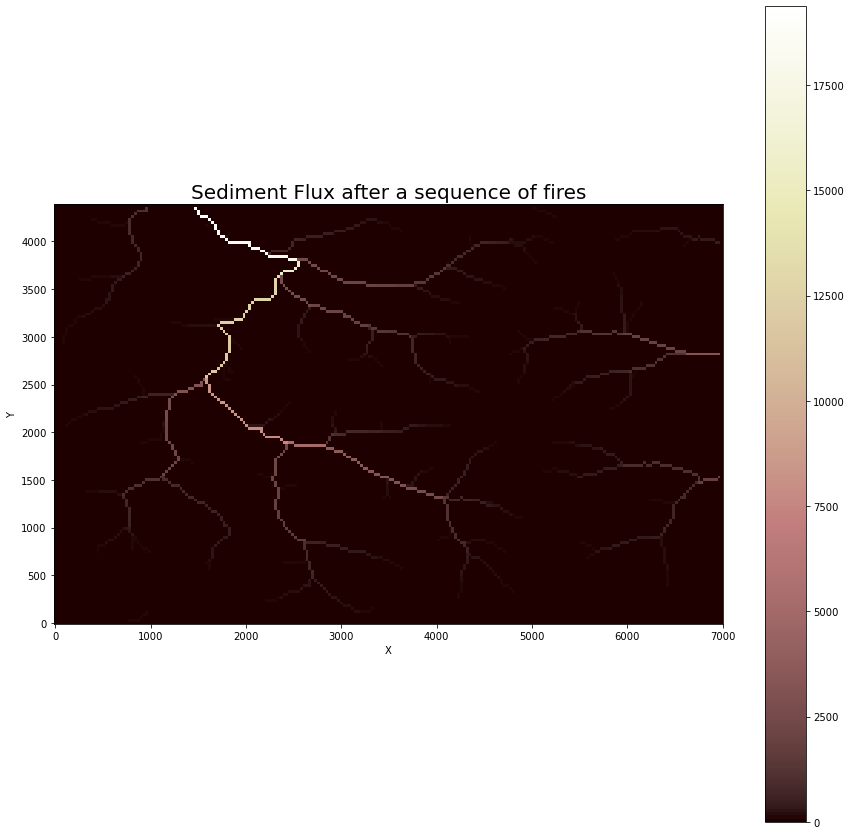

In [54]:
imshow_grid(grid, 'sediment__flux')
plt.title('Sediment Flux after a sequence of fires', fontsize=20)

Text(0.5, 1.0, 'Fire magnitudes through time')

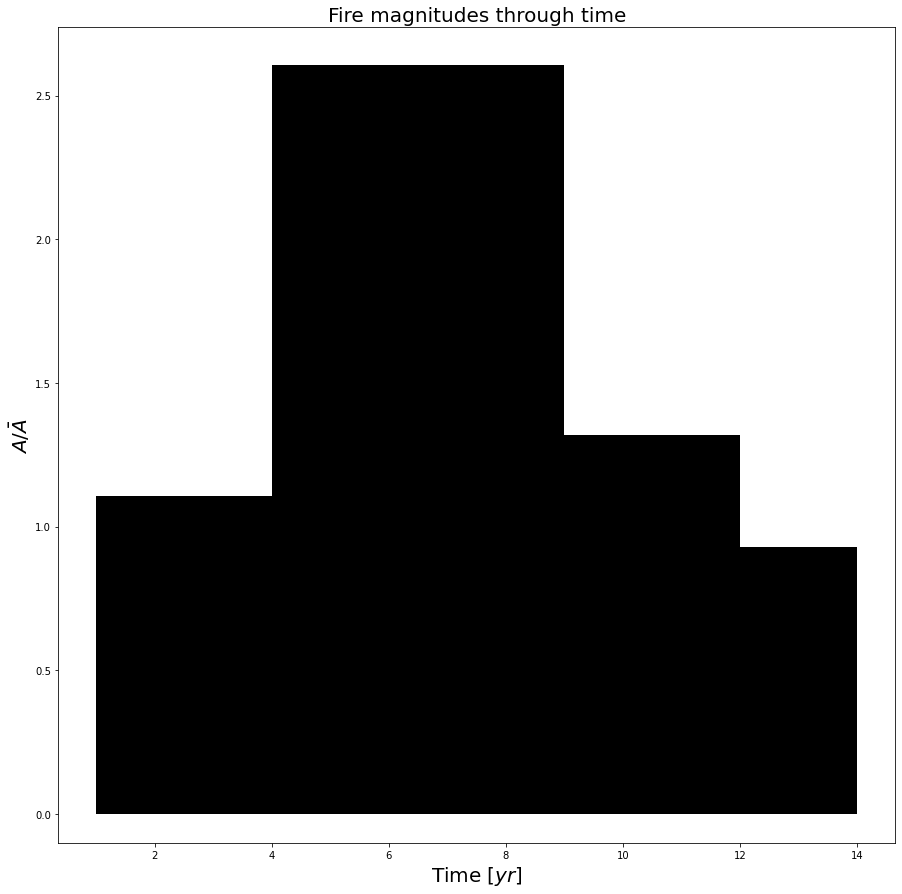

In [55]:
plt.bar(burner.fireTimes, burner.fireSizes/np.mean(burner.fireSizes), width=5, align='edge', lw=2, color='black')
plt.xlabel("Time [$yr$]", fontsize=20)
plt.ylabel(r"$A/\bar{A}$", fontsize=20)
plt.ylim(-0.1)
plt.title('Fire magnitudes through time', fontsize=20)

## 3. [Flow](https://landlab.readthedocs.io/en/master/reference/bmi/index.html?highlight=priorityflood#landlab.bmi.components.PriorityFloodFlowRouter), [BedrockLandslider](https://landlab.readthedocs.io/en/latest/reference/components/bedrock_landslider.html), and [SPACE](https://landlab.readthedocs.io/en/latest/reference/components/space.html#stream-power-with-alluvium-conservation-and-entrainment)
We run the bedrock landslider coupled with SPACE in order to simulate sediment movement. 

In [56]:
# Then we run the BedrockLandslider and SPACE
start_time = time.time()
bedrock_landslider.run_one_step(dt=timestep)
flow_accumulator.run_one_step()
depression_finder.map_depressions()        # find landscape depressions (which do not erode)
space_model.run_one_step(dt=timestep)
print(f"runtime: {str(timedelta(seconds=(time.time() - start_time)))}")

/opt/tljh/user/envs/ivy/lib/python3.9/site-packages/landlab/components/bedrock_landslider/bedrock_landslider.py:647: RuntimeWarning: divide by zero encountered in true_divide
  self.grid.dx / (1 - (slope / self._angle_int_frict) ** 2),


runtime: 0:00:08.568759


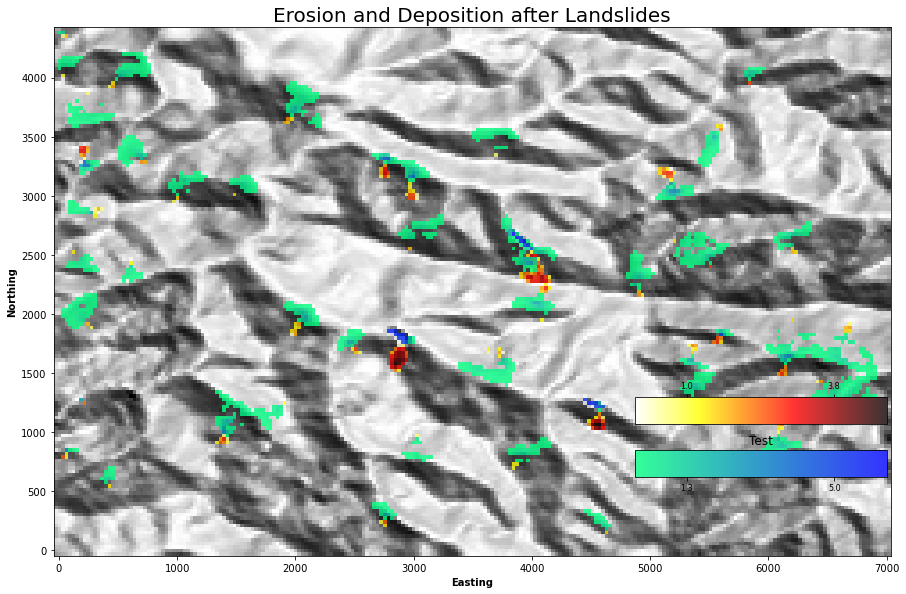

In [57]:
landslide_plot(grid)

Text(0.5, 1.0, 'Sediment Flux after running SPACE')

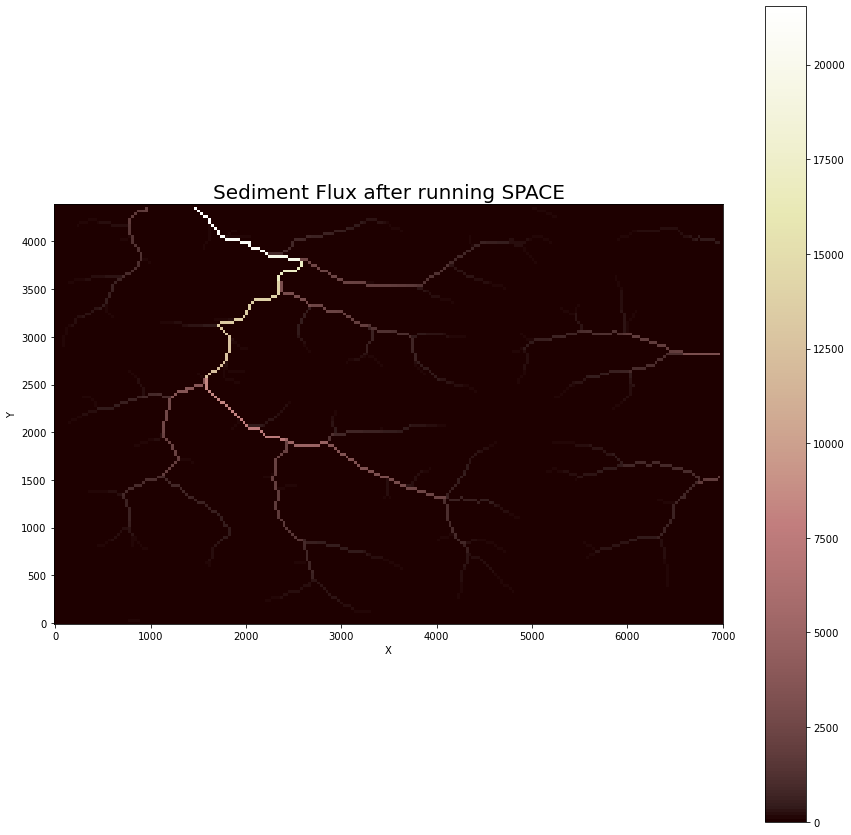

In [58]:
imshow_grid(grid, 'sediment__flux')
plt.title('Sediment Flux after running SPACE', fontsize=20)